In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter

%matplotlib inline

from utils.paths import DefaultPaths
import ipywidgets as widgets

In [2]:
paths = DefaultPaths(os.path.abspath(""))
datasets = paths.get_datasets()
options = [dataset.name for dataset in datasets]
dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Datasets:",
    disabled=False,
)
display(dropdown)

Dropdown(description='Datasets:', options=('actual__42', 'actual___42', 'actual____42', 'actual_42', 'test_42'…

In [3]:
dataset_name = dropdown.value
idx = options.index(dropdown.value)
dataset_path = datasets[idx]
metadata = dataset_path.joinpath("metadata.txt")
wavs = dataset_path.joinpath("wavs")

In [4]:
with metadata.open("r") as f:
    lines = f.readlines()

In [5]:
items = []
for line in lines:
    parts = line.split("|")
    items.append({"audio_file": wavs.joinpath(parts[0] + ".wav"), "text": parts[1]})

In [6]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = str(item["audio_file"])
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [7]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [8]:
NUM_PROC = 8


def load_item(item):
    text = item["text"].strip()
    file_name = item["audio_file"]
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len


# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(NUM_PROC) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

/tmp/ipykernel_2171/1903673131.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  data = list(tqdm(p.imap(load_item, items), total=len(items)))


  0%|          | 0/13442 [00:00<?, ?it/s]

In [9]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

/tmp/ipykernel_2171/2126754372.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/13442 [00:00<?, ?it/s]

 > Number of words: 19048


In [10]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

/tmp/ipykernel_2171/1322472053.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/13442 [00:00<?, ?it/s]

In [11]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [12]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [13]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.08712989554308129
0.11766701025459157


In [14]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf = norm.pdf(sec_per_char)
    # if pdf < 0.39:
    #     print(item)

### Plot Dataset Statistics

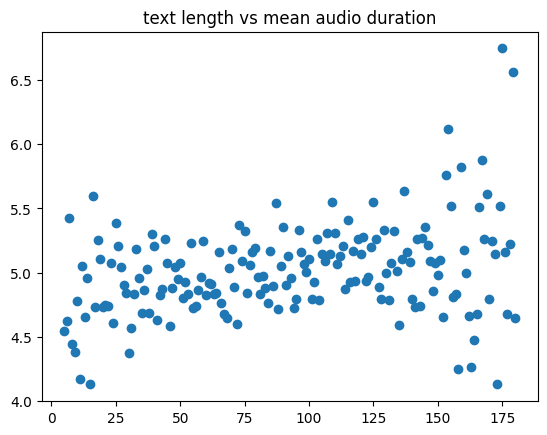

In [15]:
title = "text length vs mean audio duration"
plt.title(title)
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))
plt.savefig(f"data/datasets/{dataset_name}/{title.replace(' ','_')}")

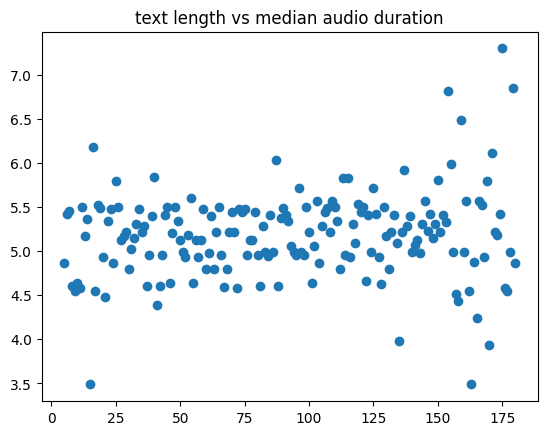

In [16]:
title = "text length vs median audio duration"
plt.title(title)
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))
plt.savefig(f"data/datasets/{dataset_name}/{title.replace(' ','_')}")

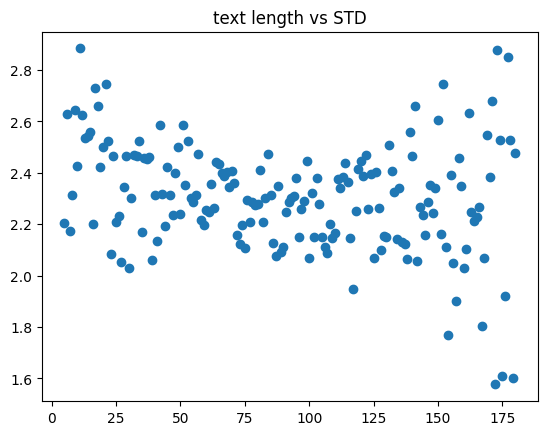

In [17]:
title = "text length vs STD"
plt.title(title)
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))
plt.savefig(f"data/datasets/{dataset_name}/{title.replace(' ','_')}")

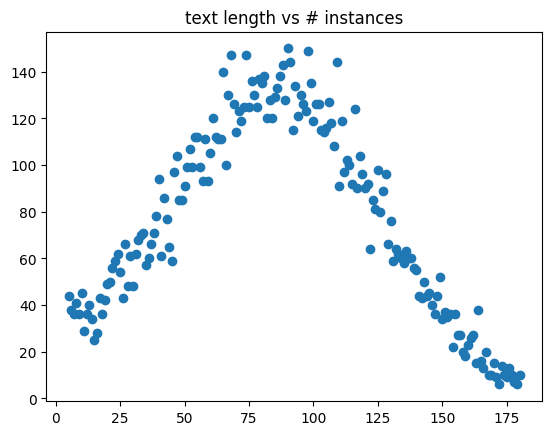

In [18]:
title = "text length vs # instances"
plt.title(title)
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))
plt.savefig(f"data/datasets/{dataset_name}/{title.replace(' ','_')}")

### Check words frequencies

In [49]:
w_count_df = pd.DataFrame.from_dict(w_count, orient="index")
w_count_df.sort_values(0, ascending=False, inplace=True)

In [50]:
w_count_df

,0
the,13543
and,6716
of,6322
to,5406
a,4449
...,...
"sovereign,",1
suppress,1
personality.,1
"harmless,",1


In [32]:
# check a certain word
w_count_df.at["minute", 0]

11

<AxesSubplot: >

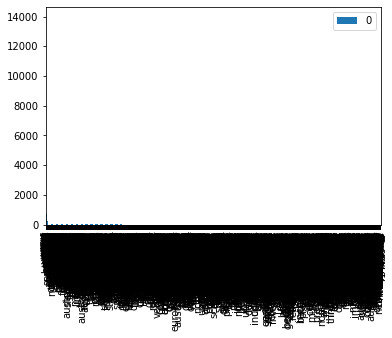

In [25]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()